# Analysis on the Mutagenicity dataset

In [1]:
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.datasets import TUDataset
ds_name = "Mutagenicity"

path = "/Users/raffaelepojer/Dev/RBN-GNN/datasets"
dataset = TUDataset(path, name=ds_name)
print(len(dataset))

4337


In [2]:
import torch
import torch.nn as nn
import torch.functional as F
import sys
sys.path.append("/Users/raffaelepojer/Dev/RBN-GNN/python/")
from gnn.ACR_graph import *

model = MYACRGnnGraph(
    input_dim=14,
    hidden_dim=[16,8,8],
    num_layers=3,
    mlp_layers=0,
    final_read="add",
    num_classes=2,
    fwd_dp=0.0,
    lin_dp=0.0,
    mlp_dp=0.0
)

criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load(f"/Users/raffaelepojer/Dev/RBN-GNN/models/Mutagenicity_16_8_8_20230814-204701/exp_33/rbn_acr_graph_Mutagenicity_16_8_8_add.pt"))
model.eval()

MYACRGnnGraph(
  (layers): ModuleList(
    (0-2): 3 x MYACRConv()
  )
  (linear): Linear(in_features=8, out_features=2, bias=True)
)

In [19]:
def display_graph(dataset, idx_dataset, node_size=500):
    print(dataset[idx_dataset].y)
    G = nx.Graph()
    G.add_nodes_from(range(dataset[idx_dataset].x.size(0)))
    G.add_edges_from(dataset[idx_dataset].edge_index.t().tolist())

    atom_labels = {
        0: "C",
        1: "O",
        2: "Cl",
        3: "H",
        4: "N",
        5: "F",
        6: "Br",
        7: "S",
        8: "P",
        9: "I",
        10: "Na",
        11: "K",
        12: "Li",
        13: "Ca"
    }

    color_map = [plt.cm.tab20(i) for i in range(len(atom_labels))]
    node_labels = [color.item() for color in np.argmax(dataset[idx_dataset].x, axis=1)]

    node_colors = [color_map[list(atom_labels.values()).index(atom_labels[label])] for label in node_labels]

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos=nx.spring_layout(G, seed=40), with_labels=True, labels={i: atom_labels[label] for i, label in enumerate(node_labels)},
            node_color=node_colors, node_size=node_size, font_size=9, font_weight='bold')

    plt.show()

In [5]:
def display_graph_single(dataset, idx_dataset):
    G = nx.Graph()
    G.add_nodes_from(range(dataset[idx_dataset].x.size(0)))
    G.add_edges_from(dataset[idx_dataset].edge_index.t().tolist())

    atom_labels = {
        0: "C",
        1: "O",
        2: "Cl",
        3: "H",
        4: "N",
        5: "F",
        6: "Br",
        7: "S",
        8: "P",
        9: "I",
        10: "Na",
        11: "K",
        12: "Li",
        13: "Ca"
    }

    color_map = [plt.cm.tab20(i) for i in range(len(atom_labels))]
    node_labels = [atom_labels[label.item()] for label in dataset[idx_dataset].x.argmax(dim=1)]

    node_colors = [color_map[list(atom_labels.keys()).index(label)] for label in dataset[idx_dataset].x.argmax(dim=1)]

    return G, node_labels, node_colors

def plot_multiple_graphs(dataset, idx_list, model, graph_class, out_dir):
    num_plots = len(idx_list)
    ncols = 3  # Number of columns in the grid
    nrows = (num_plots + ncols - 1) // ncols  # Calculate the number of rows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))  # Adjust figsize for better aspect ratio

    for i, idx in enumerate(idx_list):
        ax = axes[i // ncols, i % ncols] if num_plots > 1 else axes
        G, node_labels, node_colors = display_graph_single(dataset, idx)
        pos = nx.spring_layout(G, seed=40)
        nx.draw(G, pos=pos, with_labels=True, labels={i: label for i, label in enumerate(node_labels)},
                node_color=node_colors, node_size=250, font_size=9, font_weight='bold', ax=ax)
        
        edge_index = dataset[idx].edge_index
        x = dataset[idx].x
        y = dataset[idx].y[0].item()
        batch = torch.zeros(x.size()[0]).type(torch.LongTensor)

        out = model(x, edge_index, batch)
        m = nn.Softmax(dim=1)
        _, pred = out.max(1)
        ax.set_title(f"{m(out)[0][graph_class].item():.5f} pred:{pred[0].item()} true:{y}")

    # Remove any unused subplots
    for i in range(num_plots, nrows * ncols):
        fig.delaxes(axes[i // ncols, i % ncols])

    plt.tight_layout()
    plt.savefig(out_dir, format='pdf')
    plt.show()


### Count the total number of Br

In [6]:
br_idx = 6
br_count = 0
br_count_mut = 0
br_count_n_mut = 0
avg_br_mut = 0
avg_br_n_mut = 0
idx_dataset = 0
graph_with_br_n_mut = 0
graph_with_br_mut = 0
total_mut = 0
total_n_mut = 0

for i, sample in enumerate(dataset):
    avg_br_mut_tm = 0
    avg_br_n_mut_tm = 0
    if sample.y[0].item() == 1:
        total_n_mut += 1
    else:
        total_mut += 1

    for node in sample.x:
        if node[br_idx].item() == 1:
            br_count += 1

        if node[br_idx].item() == 1 and sample.y[0].item() == 0:
            br_count_mut += 1
            avg_br_mut_tm += 1
            if avg_br_mut_tm == 1:
                graph_with_br_mut += 1
            idx_dataset = i

        if node[br_idx].item() == 1 and sample.y[0].item() == 1:
            br_count_n_mut += 1
            avg_br_n_mut_tm += 1

            if avg_br_n_mut_tm == 1:
                graph_with_br_n_mut += 1
            
    
    avg_br_mut += avg_br_mut_tm
    avg_br_n_mut += avg_br_n_mut_tm


print("Total number of samples:", len(dataset))
print("Total number of mutagenic samples:", total_mut)
print("Total number of non-mutagenic samples:", total_n_mut)
print("Total number of Br:", br_count)
print("Mutagenic Br:", br_count_mut)
print("Non-mutagenic Br:", br_count_n_mut)
print("Average number of mutagenic Br per sample:", avg_br_mut/graph_with_br_mut)
print("Average number of non-mutagenic Br per sample:", avg_br_n_mut/graph_with_br_n_mut)


Total number of samples: 4337
Total number of mutagenic samples: 2401
Total number of non-mutagenic samples: 1936
Total number of Br: 299
Mutagenic Br: 139
Non-mutagenic Br: 160
Average number of mutagenic Br per sample: 1.5617977528089888
Average number of non-mutagenic Br per sample: 2.318840579710145


### Check probs with the model

In [7]:
edge_index = dataset[idx_dataset].edge_index

x = dataset[idx_dataset].x
batch = torch.zeros(x.size()[0]).type(torch.LongTensor)

out = model(x, edge_index, batch)
m = nn.Softmax(dim=1)
print(m(out))

tensor([[0.1615, 0.8385]], grad_fn=<SoftmaxBackward0>)


### Compute the average probability for the graphs with Br and compare with the average probability of the positive class

In [13]:
max_pos_out = 0
min_pos_out = 2
max_neg_out = 0
min_neg_out = 2
max_pos_sample = -1
min_pos_sample = -1
max_neg_sample = -1
min_neg_sample = -1
max_pos_samples = []
max_neg_samples = []
pos_samples = []
neg_samples = []
false_pos_samples = []
false_neg_samples = []

avg_out_mut = 0
avg_out_n_mut = 0
avg_out_br_mut = 0
avg_out_br_n_mut = 0
count_mut = 0
count_n_mut = 0

bigger_graph = None
biggest_idx = -1
bigger = 0
smaller = None
smaller_idx = -1
smaller = 500

for i, sample in enumerate(dataset):
    edge_index = sample.edge_index
    x = sample.x
    batch = torch.zeros(x.size()[0]).type(torch.LongTensor)

    out = model(x, edge_index, batch)
    m = nn.Softmax(dim=1)

    if sample.x.shape[0] > bigger:
        bigger = sample.x.shape[0]
        bigger_graph = sample
        biggest_idx = i
    if sample.x.shape[0] < smaller:
        smaller = sample.x.shape[0]
        smaller_graph = sample
        smaller_idx = i
    
    if m(out)[0][0].item() == 1 and sample.y[0].item() == 0:
        max_pos_samples.append(i)
    if m(out)[0][1].item() == 1 and sample.y[0].item() == 1:
        max_neg_samples.append(i)

    if m(out)[0][0].item() > max_pos_out and sample.y[0].item() == 0:
        max_pos_out = m(out)[0][0].item()
        max_pos_sample = i
    if m(out)[0][0].item() < min_pos_out and sample.y[0].item() == 0:
        min_pos_out = m(out)[0][0].item()
        min_pos_sample = i
    if m(out)[0][1].item() > max_neg_out and sample.y[0].item() == 1:
        max_neg_out = m(out)[0][1].item()
        max_neg_sample = i
    if m(out)[0][1].item() < min_neg_out and sample.y[0].item() == 1:
        min_neg_out = m(out)[0][1].item()
        min_neg_sample = i

    _, pred = out.max(1)
    if sample.y[0].item() == 0 and pred == 1:
        false_neg_samples.append((i, m(out)[0][1].item()))
    if sample.y[0].item() == 1 and pred == 0:
        false_pos_samples.append((i, m(out)[0][0].item()))
    
    if sample.y[0].item() == 0: # mut
        count_mut += 1
        avg_out_mut += m(out)[0][0].item()
        pos_samples.append((i, m(out)[0][0].item()))
        tm_mut = 0
        for node in sample.x:
            if node[br_idx].item() == 1:
                tm_mut += 1
                if tm_mut > 0:
                    avg_out_br_mut += m(out)[0][0].item()

    if sample.y[0].item() == 1: # non mut
        count_n_mut += 1
        avg_out_n_mut += m(out)[0][1].item()
        neg_samples.append((i, m(out)[0][1].item()))
        tm_n_mut = 0
        for node in sample.x:
            if node[br_idx].item() == 1:
                tm_n_mut += 1
                if tm_n_mut > 0:
                    avg_out_br_n_mut += m(out)[0][1].item()

        
avg_out_mut /= count_mut
avg_out_n_mut /= count_n_mut
avg_out_br_mut /= br_count_mut
avg_out_br_n_mut /= br_count_n_mut

print("Max prob mutag:", max_pos_out)
print("Max prob non mutag:", max_neg_out)
print("Avg prob mutagenicity:", avg_out_mut)
print("Avg prob non mutagenicity:", avg_out_n_mut)
print("Avg prob mutagenicity with br:", avg_out_br_mut)
print("Avg prob non mutagenicity with br:", avg_out_br_n_mut)

print(biggest_idx)
print(smaller_idx)

Max prob mutag: 1.0
Max prob non mutag: 1.0
Avg prob mutagenicity: 0.7704255490768228
Avg prob non mutagenicity: 0.6455188292070977
Avg prob mutagenicity with br: 0.8216116983684705
Avg prob non mutagenicity with br: 0.8422405113466084
2143
192


tensor([[0.4355, 0.5645]], grad_fn=<SoftmaxBackward0>)
tensor([1])
tensor([1])


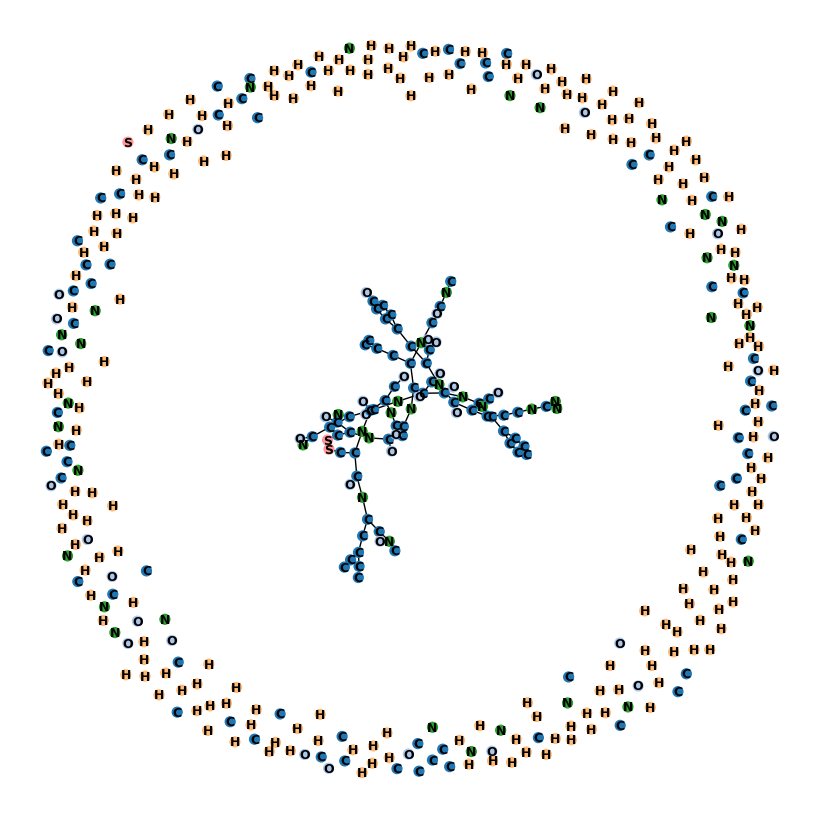

In [22]:
edge_index = dataset[biggest_idx].edge_index
x = dataset[biggest_idx].x
batch = torch.zeros(dataset[biggest_idx].x.size()[0]).type(torch.LongTensor)

out = model(x, edge_index, batch)
m = nn.Softmax(dim=1)
print(m(out))
print(dataset[biggest_idx].y)
display_graph(dataset, biggest_idx, node_size=50)

tensor([0])


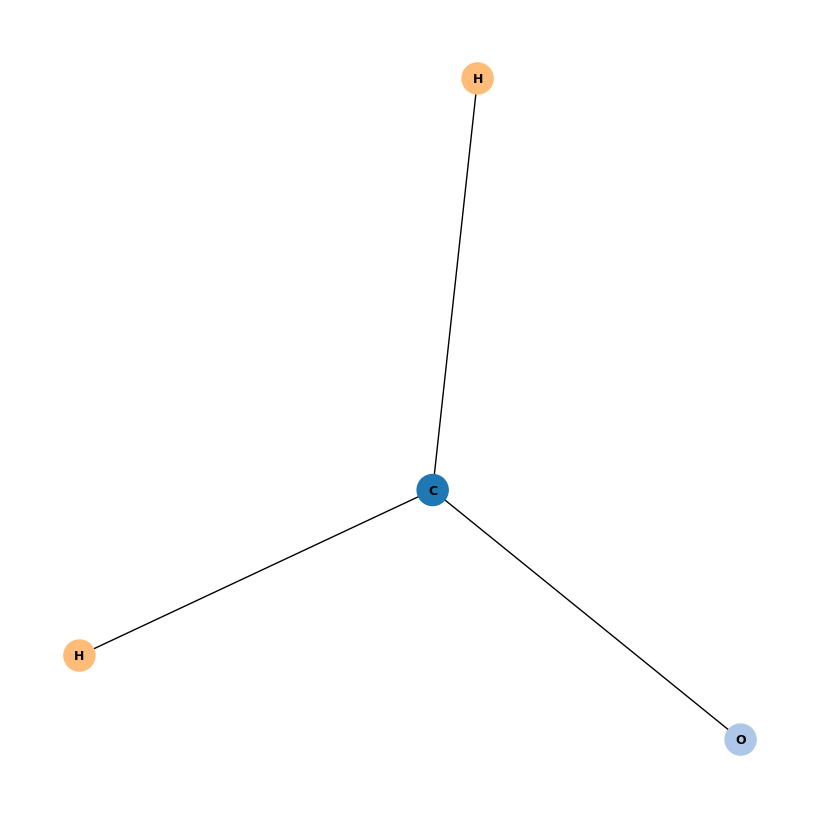

tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward0>)
tensor([0])


In [21]:
edge_index = dataset[smaller_idx].edge_index
x = dataset[smaller_idx].x
batch = torch.zeros(dataset[smaller_idx].x.size()[0]).type(torch.LongTensor)

out = model(x, edge_index, batch)
m = nn.Softmax(dim=1)
print(m(out))
print(dataset[smaller_idx].y)
display_graph(dataset, smaller_idx)

### Show the most probable graph for the positive class

[478, 1375, 2727, 4013]
[(123, 0.9874193072319031), (3114, 0.9907137155532837), (2551, 0.9916490316390991), (443, 0.9936309456825256), (3522, 0.9938598871231079), (647, 0.9957808256149292), (444, 0.9976730942726135), (3300, 0.9976795315742493), (4317, 0.9989452958106995), (1500, 0.9991556406021118)]
[2130 3091  830 2783 2450 3272  478 1375 2727 4013]
[0.99990416 0.99991977 0.9999367  0.9999541  0.99997973 0.9999814
 1.         1.         1.         1.        ]


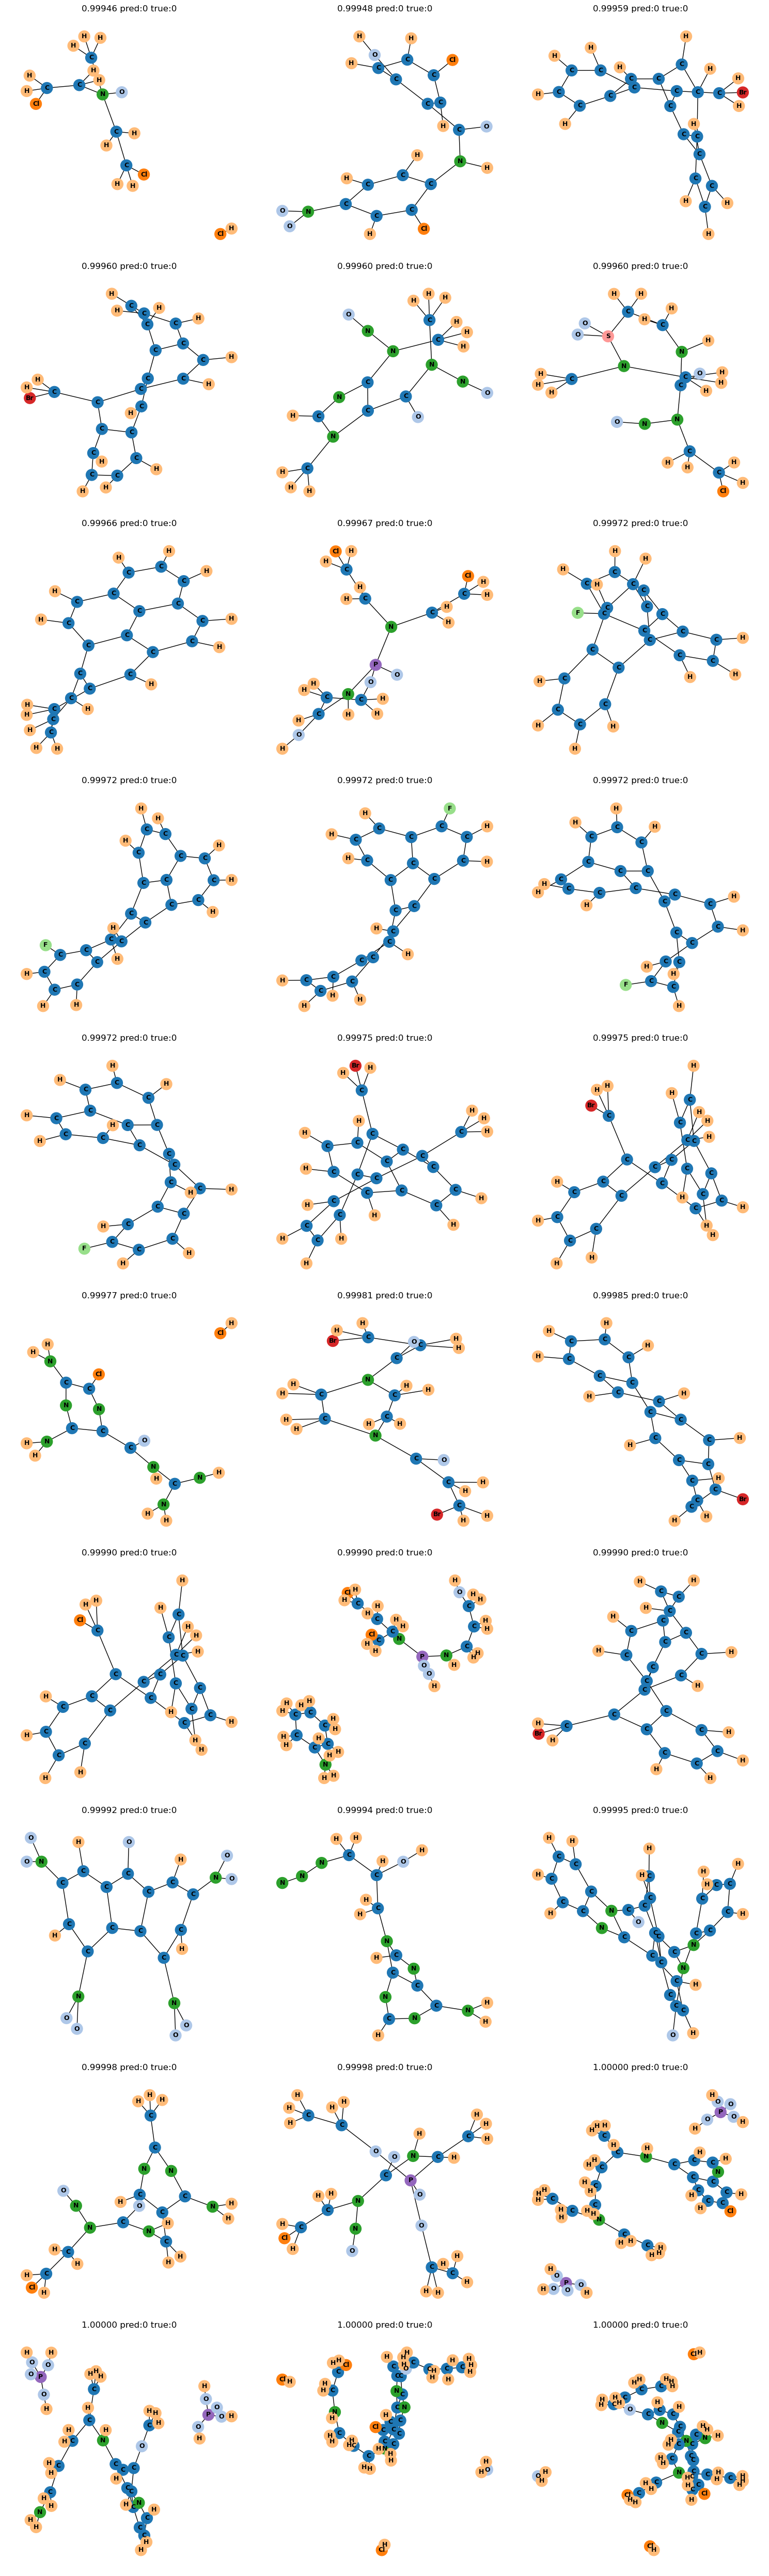

In [226]:
# display_graph(dataset, 3117)
print(max_pos_samples)
false_pos_samples = sorted(false_pos_samples, key=lambda x: x[1])
false_pos_indexes = np.array([x[0] for x in false_pos_samples])

print(false_pos_samples[-10:])
pos_samples = sorted(pos_samples, key=lambda x: x[1])
pos_values = np.array([x[1] for x in pos_samples])
pos_indexes = np.array([x[0] for x in pos_samples])
print(pos_indexes[-10:])
print(pos_values[-10:])

plot_multiple_graphs(dataset, pos_indexes[-30:], model, 0, "/Users/raffaelepojer/Dev/RBN-GNN/models/Mutagenicity_16_8_8_20230814-204701/exp_33/most_positive_samples.pdf")

### Show the most probable graph for the negative class

31
[ 166  219  470  527  852  860 1113 1119 1137 1193 1710 1893 1932 2173
 2194 2430 2487 3034 3037 3118 3310 3757 3874 3905 4002 4075 4130 4150
 4306 4314]


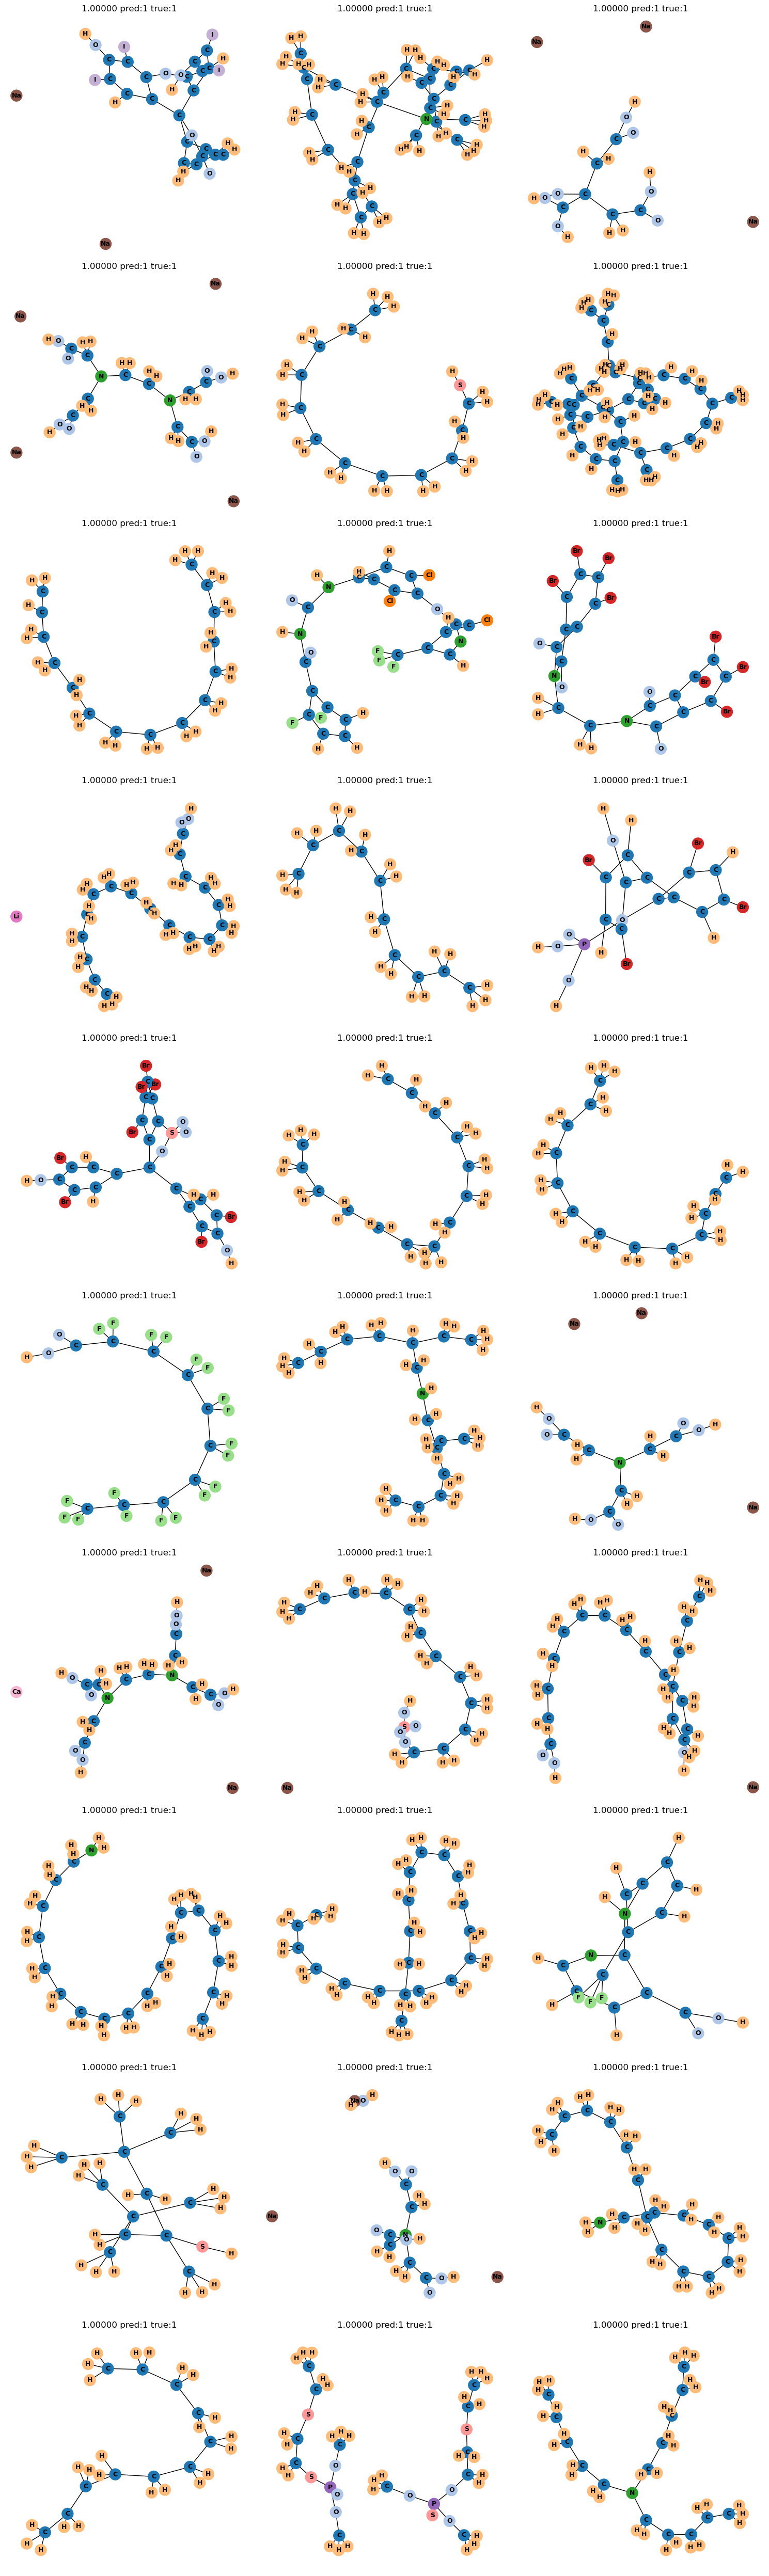

In [228]:
neg_samples = sorted(neg_samples, key=lambda x: x[1])
neg_values = np.array([x[1] for x in neg_samples])
neg_indexes = np.array([x[0] for x in neg_samples])

false_neg_samples = sorted(false_neg_samples, key=lambda x: x[1])
false_neg_indexes = np.array([x[0] for x in false_neg_samples])
print(len(max_neg_samples))
print(neg_indexes[-30:])
# display_graph(dataset, 607)
plot_multiple_graphs(dataset, neg_indexes[-30:], model, 1, "/Users/raffaelepojer/Dev/RBN-GNN/models/Mutagenicity_16_8_8_20230814-204701/exp_33/most_negative_samples.pdf")


### Count the total number of atoms for each class

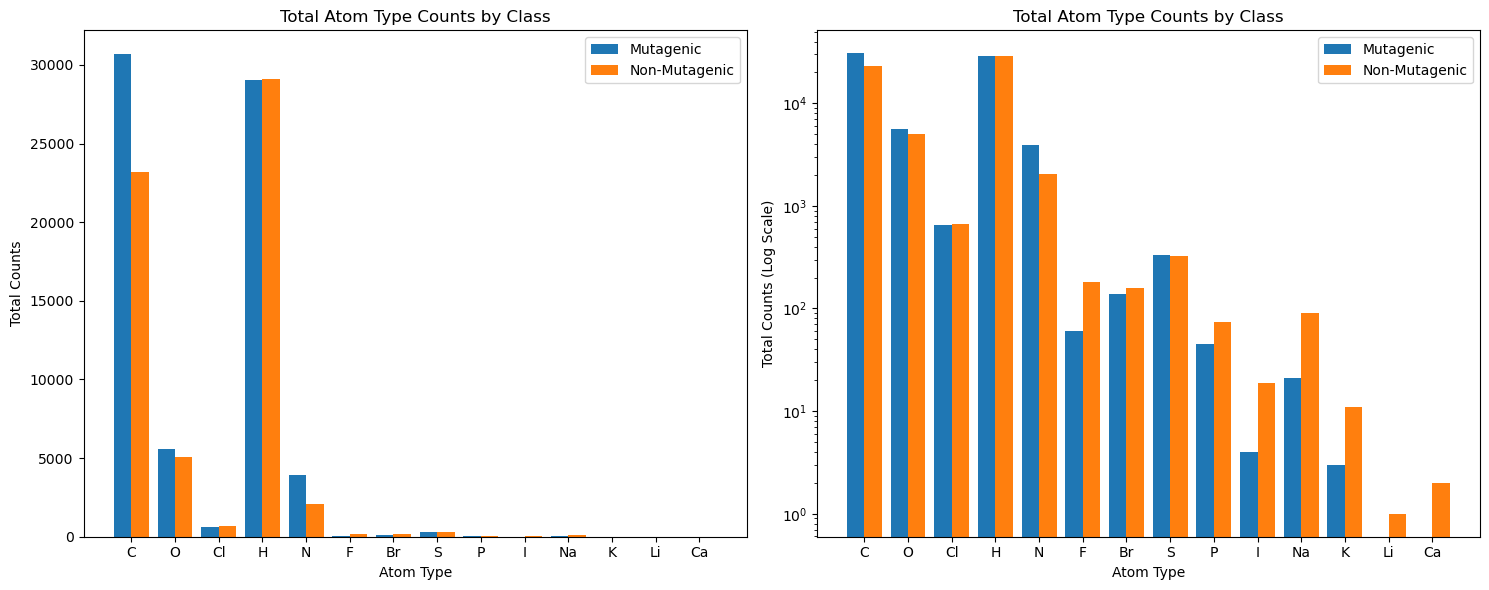

In [204]:
import torch
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt

atom_labels = {0: "C", 1: "O", 2: "Cl", 3: "H", 4: "N", 5: "F", 6: "Br", 7: "S", 8: "P", 9: "I", 10: "Na", 11: "K", 12: "Li", 13: "Ca"}
class_counts = [{}, {}]

for data in dataset:
    label = int(data.y.item())  # Class label (0 or 1)
    for node_label in data.x:
        atom_type = np.argmax(node_label, axis=0).item()
        if atom_type in class_counts[label]:
            class_counts[label][atom_type] += 1
        else:
            class_counts[label][atom_type] = 1

# Calculate total counts for each atom type by class
total_counts = [{atom_type: count for atom_type, count in class_counts[label].items()}
                for label in range(2)]

# Convert the counts to lists for plotting
class_labels = ["Mutagenic", "Non-Mutagenic"]
atom_types = [atom_labels[i] for i in range(len(atom_labels))]

class_0_counts = [total_counts[0].get(i, 0) for i in range(len(atom_labels))]
class_1_counts = [total_counts[1].get(i, 0) for i in range(len(atom_labels))]

# Create subplots with two plots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

bar_width = 0.4  # Width of the bars
index = np.arange(len(atom_types))  # X positions for the bars

# Regular scale plot
axs[0].bar(index, class_0_counts, width=bar_width, label=class_labels[0])
axs[0].bar(index + bar_width, class_1_counts, width=bar_width, label=class_labels[1])
axs[0].set_xlabel('Atom Type')
axs[0].set_ylabel('Total Counts')
axs[0].set_title('Total Atom Type Counts by Class')
axs[0].set_xticks(index + bar_width / 2)
axs[0].set_xticklabels(atom_types)
axs[0].legend()

# Log scale plot
axs[1].bar(index, class_0_counts, width=bar_width, label=class_labels[0])
axs[1].bar(index + bar_width, class_1_counts, width=bar_width, label=class_labels[1])
axs[1].set_yscale('log')
axs[1].set_xlabel('Atom Type')
axs[1].set_ylabel('Total Counts (Log Scale)')
axs[1].set_title('Total Atom Type Counts by Class')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(atom_types)
axs[1].legend()

plt.tight_layout()
plt.show()


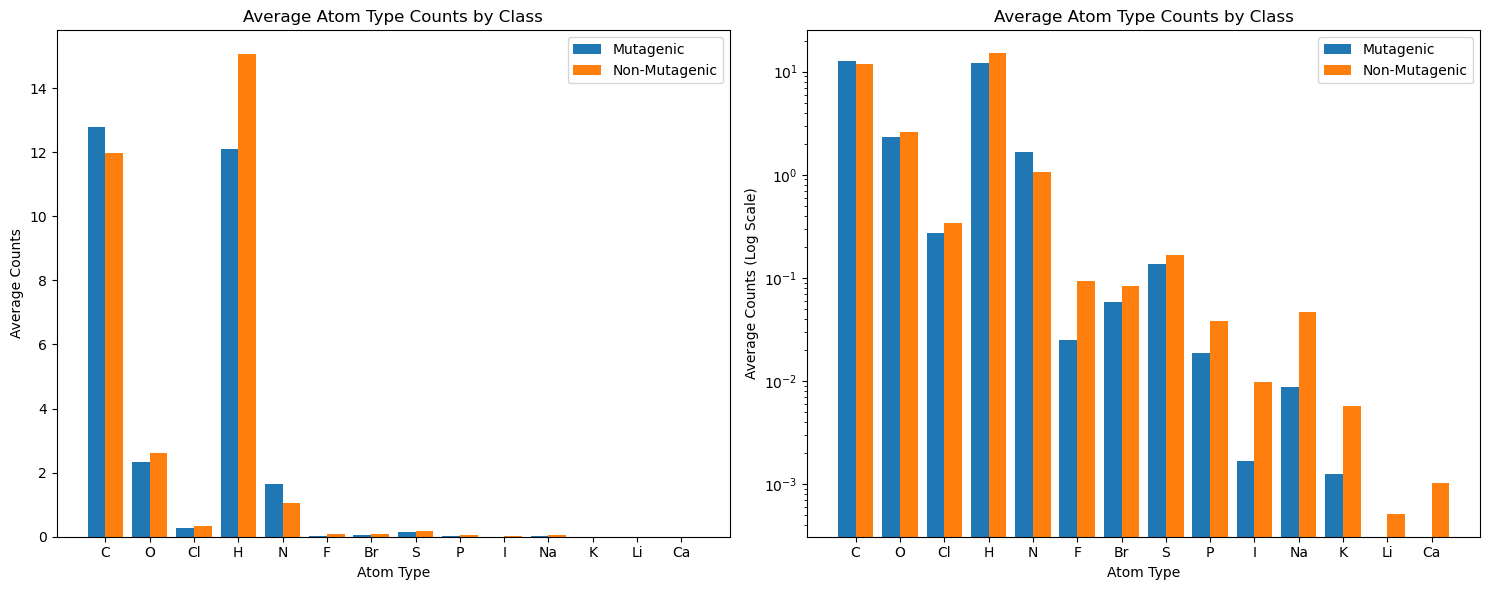

In [205]:
import torch
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt

# Replace this with your code to load the Mutagenicity dataset
# dataset = torch_geometric.datasets.MUTAG(root='path_to_dataset', download=True)

atom_labels = {0: "C", 1: "O", 2: "Cl", 3: "H", 4: "N", 5: "F", 6: "Br", 7: "S", 8: "P", 9: "I", 10: "Na", 11: "K", 12: "Li", 13: "Ca"}
class_counts = [{}, {}]

for data in dataset:
    label = int(data.y.item())  # Class label (0 or 1)
    for node_label in data.x:
        atom_type = np.argmax(node_label, axis=0).item()
        if atom_type in class_counts[label]:
            class_counts[label][atom_type] += 1
        else:
            class_counts[label][atom_type] = 1

# Count the total number of graphs in each class
num_graphs = [0, 0]
for data in dataset:
    label = int(data.y.item())
    num_graphs[label] += 1

# Calculate average counts for each atom type by class
average_counts = [{atom_type: count / num_graphs[label] for atom_type, count in class_counts[label].items()}
                  for label in range(2)]

# Convert the counts to lists for plotting
class_labels = ["Mutagenic", "Non-Mutagenic"]
atom_types = [atom_labels[i] for i in range(len(atom_labels))]

class_0_counts = [average_counts[0].get(i, 0) for i in range(len(atom_labels))]
class_1_counts = [average_counts[1].get(i, 0) for i in range(len(atom_labels))]

# Create subplots with two plots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

bar_width = 0.4  # Width of the bars
index = np.arange(len(atom_types))  # X positions for the bars

# Regular scale plot
axs[0].bar(index, class_0_counts, width=bar_width, label=class_labels[0])
axs[0].bar(index + bar_width, class_1_counts, width=bar_width, label=class_labels[1])
axs[0].set_xlabel('Atom Type')
axs[0].set_ylabel('Average Counts')
axs[0].set_title('Average Atom Type Counts by Class')
axs[0].set_xticks(index + bar_width / 2)
axs[0].set_xticklabels(atom_types)
axs[0].legend()

# Log scale plot
axs[1].bar(index, class_0_counts, width=bar_width, label=class_labels[0])
axs[1].bar(index + bar_width, class_1_counts, width=bar_width, label=class_labels[1])
axs[1].set_yscale('log')
axs[1].set_xlabel('Atom Type')
axs[1].set_ylabel('Average Counts (Log Scale)')
axs[1].set_title('Average Atom Type Counts by Class')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(atom_types)
axs[1].legend()

plt.tight_layout()
plt.show()
